In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import tensorflow as tf
from PIL import Image
from keras.applications.vgg16 import preprocess_input
import numpy as np

Using TensorFlow backend.


------

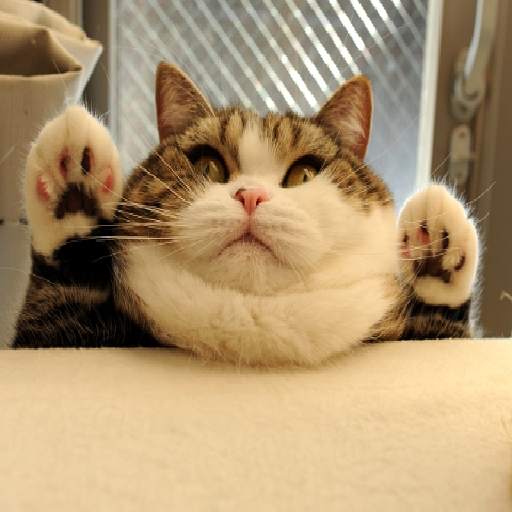

In [4]:
height = 512
width = 512

content_image_path = 'images/maru.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

In [5]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

------

In [6]:
def net(image):
    conv1 = conv(image, 32, 9, 1)
    conv2 = conv(conv1, 64, 3, 2)
    conv3 = conv(conv2, 128, 3, 2)
    
    resid1 = res_block(conv3, 3)
    resid2 = res_block(resid1, 3)
    resid3 = res_block(resid2, 3)
    resid4 = res_block(resid3, 3)
    resid5 = res_block(resid4, 3)
    
    conv_t1 = up_conv(resid5, 64, 3, 2)
    conv_t2 = up_conv(conv_t1, 32, 3, 2)
    conv_t3 = conv(conv_t2, 3, 9, 1, relu=False)
    
    preds = tf.nn.tanh(conv_t3) * 150 + 255./2
    return preds

def conv(net, num_filters, filter_size, strides, relu=True):
    weights_init = init_layer(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    
    net = tf.nn.conv2d(net, weights_init, strides_shape, padding='SAME')
    net = instance_norm(net) # Normalization
    
    if relu:
        net = tf.nn.relu(net)

    return net

def up_conv(net, num_filters, filter_size, strides):
    weights_init = init_layer(net, num_filters, filter_size, transpose=True)

    batch_size, rows, cols, in_channels = [i.value for i in net.get_shape()]
    new_rows, new_cols = int(rows * strides), int(cols * strides)

    new_shape = [batch_size, new_rows, new_cols, num_filters]
    tf_shape = tf.stack(new_shape)
    strides_shape = [1, strides, strides, 1]

    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')
    net = instance_norm(net) # Normalization
    return tf.nn.relu(net)

def res_block(net, filter_size=3):
    tmp = conv(net, 128, filter_size, 1)
    return net + conv(tmp, 128, filter_size, 1, relu=False)

def instance_norm(net, train=True):
    batch, rows, cols, channels = [i.value for i in net.get_shape()]
    var_shape = [channels]
    
    pass

def init_layer(net, out_channels, filter_size, transpose=False):
    _, rows, cols, in_channels = [i.value for i in net.get_shape()]
    
    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.truncated_normal(weights_shape, stddev=0.1, seed=1), dtype=tf.float32)
    return weights_init

----------

In [7]:
style_net = 'data/wave.ckpt'

In [8]:
g = tf.Graph()
curr_num = 0
soft_config = tf.ConfigProto(allow_soft_placement=True)
soft_config.gpu_options.allow_growth = True

with g.as_default(), tf.Session(config=soft_config) as sess:
    batch_shape = (1, 512, 512, 3)
    img_placeholder = tf.placeholder(tf.float32, shape=batch_shape, name='img_placeholder')

    input_ph = net(img_placeholder)
    
    saver = tf.train.Saver()
    saver.restore(sess, style_net)
        
    preds = sess.run(input_ph, feed_dict={img_placeholder:content_array})

INFO:tensorflow:Restoring parameters from data/wave.ckpt


--------

In [9]:
x = preds.reshape((height, width, 3))
x = np.clip(x, 0, 255).astype('uint8')

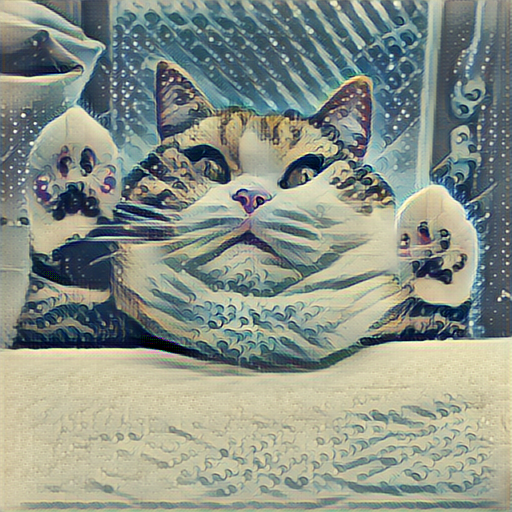

In [10]:
Image.fromarray(x)